In [1]:
import pandas as pd


phrases_df = pd.read_csv('ai_phrase_classification.csv')

In [2]:
phrases_df.columns

Index(['Phrase', 'Similarity to Market-Facing AI',
       'Similarity to Operational AI', 'Classification'],
      dtype='object')

In [3]:
phrases_df.columns = ['phrase', 'marketing_similarity',
       'operational_similarity', 'Classification']

In [4]:


# %%
import os
import re
import pandas as pd
from bs4 import BeautifulSoup
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

# Allow SentenceTransformer to use all CPU threads
torch.set_num_threads(os.cpu_count())

# %%
def clean_html(text: str) -> str:
    """Strip HTML tags and collapse whitespace."""
    soup = BeautifulSoup(text, 'lxml')
    cleaned = soup.get_text(separator=' ')
    return re.sub(r"\s+", " ", cleaned).strip()


def chunk_text(text: str, max_words: int = 500) -> list:
    """Split text into chunks of up to max_words each."""
    words = text.split()
    return [" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

# %%
# Configuration
folder_path = '10k_submissions'  # directory with .txt files of HTML dumps
#phrases_df = pd.read_csv('phrases_similarity.csv')  # CSV with columns: phrase, marketing_similarity, operational_similarity
phrase_list = phrases_df['phrase'].tolist()
model_name = 'all-MiniLM-L6-v2'
batch_size_chunks = 8  # number of chunks per batch during embedding

# Pre-embed phrases once to avoid redundant work
master_model = SentenceTransformer(model_name)
phrase_embeddings = master_model.encode(
    phrase_list,
    convert_to_numpy=True,
    batch_size=batch_size_chunks,
    show_progress_bar=True
)

# %% [markdown]
# Phase 1: Sequential Cleaning of HTML Files

# %%
# List all text files
txt_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.txt')]
print(f"Cleaning {len(txt_files)} files sequentially...")

# Clean one file at a time with progress bar
cleaned_dict = {}
for fname in tqdm(txt_files, desc='Cleaning HTML files', unit='file'):
    path = os.path.join(folder_path, fname)
    try:
        raw = open(path, encoding='utf-8', errors='ignore').read()
    except Exception as e:
        tqdm.write(f"⚠️ Could not read {fname}: {e}")
        continue
    cleaned_dict[fname] = clean_html(raw)

# %% [markdown]
# Phase 2: Sequential Embedding & Scoring

# %%
model = SentenceTransformer(model_name)
records = []
for fname in tqdm(txt_files, desc='Embedding & Scoring', unit='file'):
    cleaned = cleaned_dict.get(fname)
    if not cleaned:
        tqdm.write(f"⚠️ Skipping {fname} (no cleaned text)")
        continue

    # Chunk long text
    chunks = chunk_text(cleaned, max_words=500)
    if not chunks:
        continue

    # Embed all chunks in one batch
    embeddings = model.encode(
        chunks,
        convert_to_numpy=True,
        batch_size=batch_size_chunks,
        show_progress_bar=False
    )
    # Average chunk embeddings
    doc_emb = embeddings.mean(axis=0)

    # Compute cosine similarities
    sims = cosine_similarity(doc_emb.reshape(1, -1), phrase_embeddings).flatten()
    m_scores = phrases_df['marketing_similarity'].values
    o_scores = phrases_df['operational_similarity'].values

    # Weighted sums
    net_marketing = float((sims * m_scores).sum())
    net_operational = float((sims * o_scores).sum())

    records.append({
        'filename': fname,
        'phrases': '; '.join(phrase_list),
        'net_marketing_similarity': net_marketing,
        'net_operational_similarity': net_operational
    })

# %% [markdown]
# Save Results

# %%
result_df = pd.DataFrame(records)
output_file = 'document_similarities.csv'
result_df.to_csv(output_file, index=False)
print(f"✅ Saved to {output_file}")
result_df.head()


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Cleaning 3218 files sequentially...


Cleaning HTML files:   0%|          | 0/3218 [00:00<?, ?file/s]

Embedding & Scoring:   0%|          | 0/3218 [00:00<?, ?file/s]

✅ Saved to document_similarities.csv


,filename,phrases,net_marketing_similarity,net_operational_similarity
0,0000001800_19.txt,Pattern recognition; Robotic process automatio...,1.648433,1.463291
1,0000001800_20.txt,Pattern recognition; Robotic process automatio...,1.841865,1.606707
2,0000001800_21.txt,Pattern recognition; Robotic process automatio...,2.070329,1.852226
3,0000001800_22.txt,Pattern recognition; Robotic process automatio...,1.455776,1.301389
4,0000001800_23.txt,Pattern recognition; Robotic process automatio...,2.717430,2.494677


In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

# — assume you still have:
# cleaned_dict      : dict of {filename: cleaned_text}
# model             : your SentenceTransformer instance
# phrase_list       : list of all phrases
# phrase_embeddings : numpy array of shape (n_phrases, emb_dim)
# phrases_df        : the DataFrame with marketing/operational scores

records = []
for fname, cleaned in tqdm(cleaned_dict.items(), desc="Computing sims", unit="file"):
    # embed document (already chunked/averaged in your last run; 
    # if you only have the full cleaned text, you can re-chunk & re-avg here)
    chunks = chunk_text(cleaned, max_words=500)
    embs = model.encode(chunks, convert_to_numpy=True,
                        batch_size=batch_size_chunks, show_progress_bar=False)
    doc_emb = embs.mean(axis=0)[None, :]                # shape (1, D)

    # per-phrase similarities
    sims = cosine_similarity(doc_emb, phrase_embeddings).flatten()  # shape (n_phrases,)

    # build one record: filename + one column per phrase + the nets
    row = {"filename": fname}
    row.update({ phrase: float(sim) for phrase, sim in zip(phrase_list, sims) })

    # net scores (you can also pull these from your old result_df if you want)
    m_scores = phrases_df["marketing_similarity"].values
    o_scores = phrases_df["operational_similarity"].values
    row["net_marketing_similarity"]   = float((sims * m_scores).sum())
    row["net_operational_similarity"] = float((sims * o_scores).sum())

    records.append(row)

# assemble and save
detailed_df = pd.DataFrame(records)
detailed_df.to_csv("detailed_similarities.csv", index=False)
detailed_df.head()


Computing sims:   0%|          | 0/3218 [00:00<?, ?file/s]

,filename,Pattern recognition,Robotic process automation,Predictive analytics,Data pipelines,MathWorks,Speech recognition,Robotic,Cognitive framework,Python,...,Intelligent image analysis,Oneshot learning,Machine bias,Alteryx,Image processing,Pooling,Training data,SAS,net_marketing_similarity,net_operational_similarity
0,0000001800_19.txt,0.094240,-0.033654,0.075047,-0.007984,0.078382,0.066768,0.018570,0.018438,-0.003617,...,0.110565,0.030737,0.052393,0.151493,0.069382,0.069523,0.109391,0.209744,1.648433,1.463291
1,0000001800_20.txt,0.082669,-0.056725,0.094709,0.068912,0.132704,0.117923,-0.025358,0.064419,-0.005798,...,0.028715,0.035824,0.050111,0.089812,0.022147,0.025935,0.141443,0.169775,1.841865,1.606707
2,0000001800_21.txt,0.092317,-0.030445,0.089178,0.095076,0.133283,0.130018,-0.008370,0.093464,0.002688,...,0.035492,0.036944,0.060410,0.068064,0.046241,0.038039,0.155063,0.177768,2.070329,1.852226
3,0000001800_22.txt,0.060970,-0.054621,0.102555,0.061953,0.126044,0.099366,-0.020667,0.069527,-0.025192,...,0.037032,0.028315,0.038879,0.073742,0.023362,0.018968,0.134627,0.178061,1.455776,1.301389
4,0000001800_23.txt,0.144420,0.049809,0.105966,0.116924,0.166353,0.169186,0.091685,0.103463,0.092891,...,0.062759,0.113543,0.122492,0.033474,0.094869,0.112751,0.143238,0.163969,2.717430,2.494677


In [9]:
import numpy as np

# 1. Build masks: one array of 1s for operational phrases, one for marketing
mask_oper = (phrases_df["Classification"] == "Operational").astype(int).values
mask_mkt  = (phrases_df["Classification"] == "Market-Facing").astype(int).values

# 2. Extract the per‐phrase similarity matrix (n_docs × n_phrases)
S = detailed_df[phrase_list].values  # shape (n_docs, n_phrases)

# 3. Compute weighted sums for each doc
weighted_oper_sum = S.dot(mask_oper)   # shape (n_docs,)
weighted_mkt_sum  = S.dot(mask_mkt)

# 4. (Optional) Compute average similarity per group
#    i.e. divide by number of phrases in each class
n_oper = mask_oper.sum()
n_mkt  = mask_mkt.sum()
weighted_oper_avg = weighted_oper_sum / n_oper
weighted_mkt_avg  = weighted_mkt_sum  / n_mkt

# 5. Attach to your DataFrame
detailed_df["weighted_operational_sum"]   = weighted_oper_sum
detailed_df["weighted_marketing_sum"]     = weighted_mkt_sum
detailed_df["avg_operational_similarity"] = weighted_oper_avg
detailed_df["avg_marketing_similarity"]   = weighted_mkt_avg

# 6. Final classification per document
detailed_df["document_classification"] = np.where(
    detailed_df["weighted_marketing_sum"] > detailed_df["weighted_operational_sum"],
    "Market-Facing",
    "Operational"
)

# 7. Inspect
detailed_df.head()


,filename,Pattern recognition,Robotic process automation,Predictive analytics,Data pipelines,MathWorks,Speech recognition,Robotic,Cognitive framework,Python,...,Pooling,Training data,SAS,net_marketing_similarity,net_operational_similarity,weighted_operational_sum,weighted_marketing_sum,avg_operational_similarity,avg_marketing_similarity,document_classification
0,0000001800_19.txt,0.094240,-0.033654,0.075047,-0.007984,0.078382,0.066768,0.018570,0.018438,-0.003617,...,0.069523,0.109391,0.209744,1.648433,1.463291,3.486917,4.629032,0.077487,0.060908,Market-Facing
1,0000001800_20.txt,0.082669,-0.056725,0.094709,0.068912,0.132704,0.117923,-0.025358,0.064419,-0.005798,...,0.025935,0.141443,0.169775,1.841865,1.606707,3.469058,5.685088,0.077090,0.074804,Market-Facing
2,0000001800_21.txt,0.092317,-0.030445,0.089178,0.095076,0.133283,0.130018,-0.008370,0.093464,0.002688,...,0.038039,0.155063,0.177768,2.070329,1.852226,4.062166,6.073884,0.090270,0.079920,Market-Facing
3,0000001800_22.txt,0.060970,-0.054621,0.102555,0.061953,0.126044,0.099366,-0.020667,0.069527,-0.025192,...,0.018968,0.134627,0.178061,1.455776,1.301389,3.106495,4.069391,0.069033,0.053545,Market-Facing
4,0000001800_23.txt,0.144420,0.049809,0.105966,0.116924,0.166353,0.169186,0.091685,0.103463,0.092891,...,0.112751,0.143238,0.163969,2.717430,2.494677,5.325288,7.589956,0.118340,0.099868,Market-Facing


In [10]:
import re

# 1. Extract CIK and year
#    This regex grabs all digits before `_` and the two (or more) digits after, before `.txt`
detailed_df[['CIK','year']] = detailed_df['filename'].str.extract(
    r'(?P<CIK>\d+?)_(?P<year>\d+)\.txt'
)

# 2. (Optional) Convert types
detailed_df['CIK']  = detailed_df['CIK'].astype(str)
detailed_df['year'] = detailed_df['year'].astype(int).apply(lambda y: 2000 + y if y < 100 else y)

# 3. Reorder columns if you like
cols = ['CIK','year'] + [c for c in detailed_df.columns if c not in ('filename','CIK','year')]
final_df = detailed_df[cols]

final_df.head()


,CIK,year,Pattern recognition,Robotic process automation,Predictive analytics,Data pipelines,MathWorks,Speech recognition,Robotic,Cognitive framework,...,Pooling,Training data,SAS,net_marketing_similarity,net_operational_similarity,weighted_operational_sum,weighted_marketing_sum,avg_operational_similarity,avg_marketing_similarity,document_classification
0,0000001800,2019,0.094240,-0.033654,0.075047,-0.007984,0.078382,0.066768,0.018570,0.018438,...,0.069523,0.109391,0.209744,1.648433,1.463291,3.486917,4.629032,0.077487,0.060908,Market-Facing
1,0000001800,2020,0.082669,-0.056725,0.094709,0.068912,0.132704,0.117923,-0.025358,0.064419,...,0.025935,0.141443,0.169775,1.841865,1.606707,3.469058,5.685088,0.077090,0.074804,Market-Facing
2,0000001800,2021,0.092317,-0.030445,0.089178,0.095076,0.133283,0.130018,-0.008370,0.093464,...,0.038039,0.155063,0.177768,2.070329,1.852226,4.062166,6.073884,0.090270,0.079920,Market-Facing
3,0000001800,2022,0.060970,-0.054621,0.102555,0.061953,0.126044,0.099366,-0.020667,0.069527,...,0.018968,0.134627,0.178061,1.455776,1.301389,3.106495,4.069391,0.069033,0.053545,Market-Facing
4,0000001800,2023,0.144420,0.049809,0.105966,0.116924,0.166353,0.169186,0.091685,0.103463,...,0.112751,0.143238,0.163969,2.717430,2.494677,5.325288,7.589956,0.118340,0.099868,Market-Facing


In [11]:
final_df.to_csv('final_document_classifications.csv', index=False)

In [12]:
final_df.columns

Index(['CIK', 'year', 'Pattern recognition', 'Robotic process automation',
       'Predictive analytics', 'Data pipelines', 'MathWorks',
       'Speech recognition', 'Robotic', 'Cognitive framework',
       ...
       'Pooling', 'Training data', 'SAS', 'net_marketing_similarity',
       'net_operational_similarity', 'weighted_operational_sum',
       'weighted_marketing_sum', 'avg_operational_similarity',
       'avg_marketing_similarity', 'document_classification'],
      dtype='object', length=130)

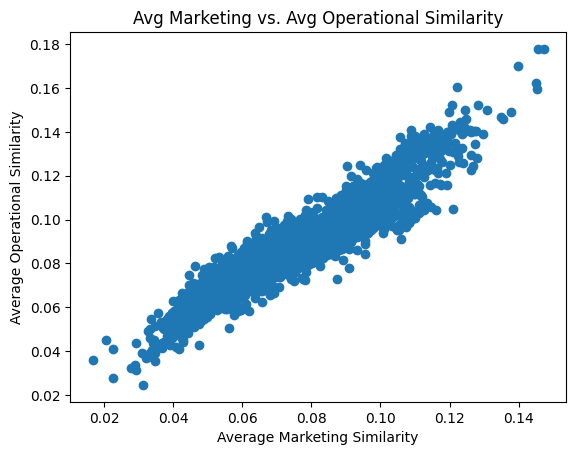

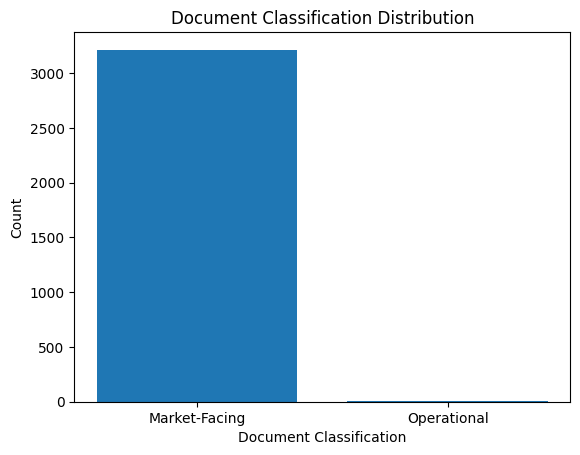

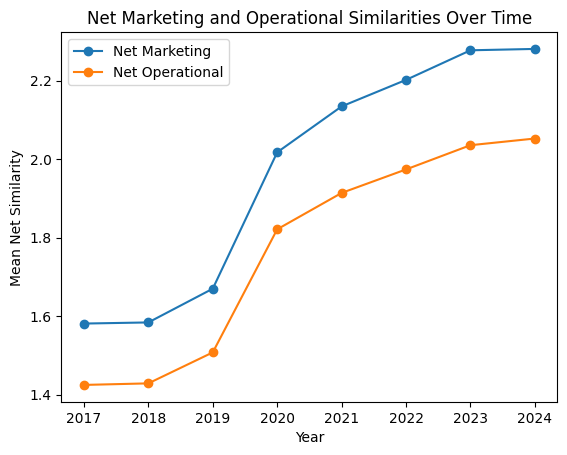

In [13]:
import matplotlib.pyplot as plt

# 1. Scatter plot: Avg Marketing vs Avg Operational Similarity
plt.figure()
plt.scatter(final_df['avg_marketing_similarity'], final_df['avg_operational_similarity'])
plt.xlabel('Average Marketing Similarity')
plt.ylabel('Average Operational Similarity')
plt.title('Avg Marketing vs. Avg Operational Similarity')
plt.show()

# 2. Bar chart: Document Classification Counts
counts = final_df['document_classification'].value_counts()
plt.figure()
plt.bar(counts.index, counts.values)
plt.xlabel('Document Classification')
plt.ylabel('Count')
plt.title('Document Classification Distribution')
plt.show()

# 3. Time series: Mean Net Similarities by Year
yearly = final_df.groupby('year')[['net_marketing_similarity', 'net_operational_similarity']].mean().reset_index()
plt.figure()
plt.plot(yearly['year'], yearly['net_marketing_similarity'], marker='o')
plt.plot(yearly['year'], yearly['net_operational_similarity'], marker='o')
plt.xlabel('Year')
plt.ylabel('Mean Net Similarity')
plt.title('Net Marketing and Operational Similarities Over Time')
plt.legend(['Net Marketing', 'Net Operational'])
plt.show()


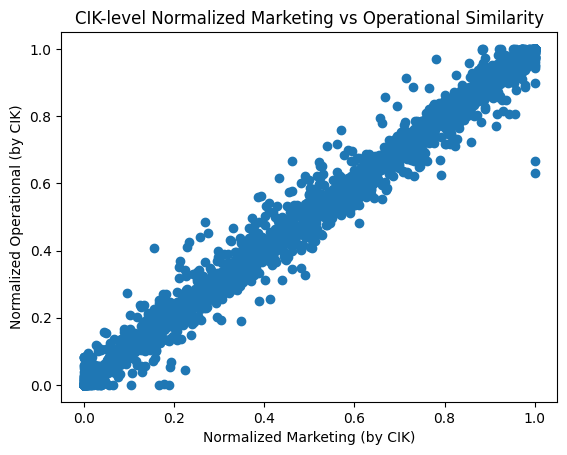

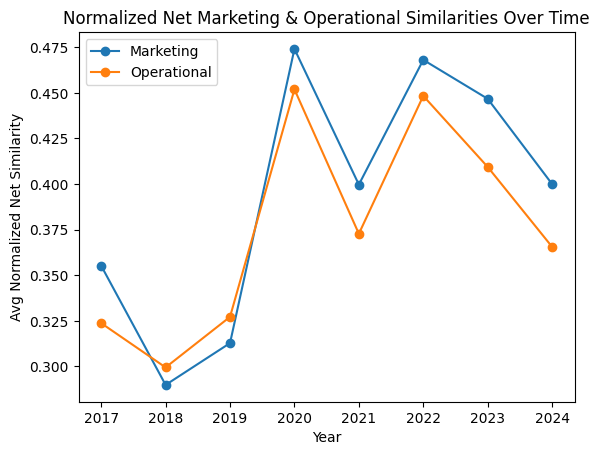

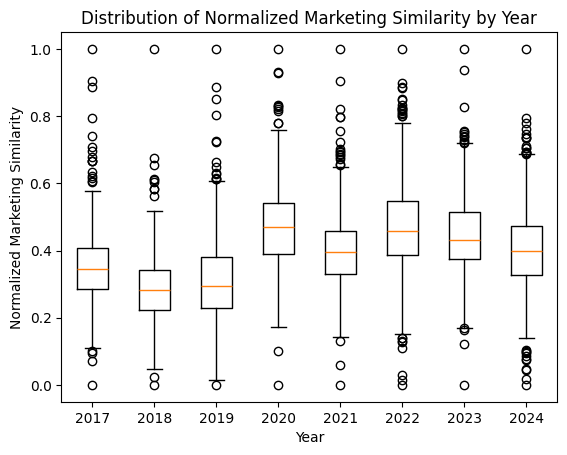

In [14]:
import matplotlib.pyplot as plt

# 1. Min-max normalization by CIK
final_df['net_marketing_norm_cik'] = final_df.groupby('CIK')['net_marketing_similarity'] \
    .transform(lambda x: (x - x.min())/(x.max() - x.min()) if x.max() != x.min() else 0)
final_df['net_operational_norm_cik'] = final_df.groupby('CIK')['net_operational_similarity'] \
    .transform(lambda x: (x - x.min())/(x.max() - x.min()) if x.max() != x.min() else 0)

# 2. Min-max normalization by Year
final_df['net_marketing_norm_year'] = final_df.groupby('year')['net_marketing_similarity'] \
    .transform(lambda x: (x - x.min())/(x.max() - x.min()) if x.max() != x.min() else 0)
final_df['net_operational_norm_year'] = final_df.groupby('year')['net_operational_similarity'] \
    .transform(lambda x: (x - x.min())/(x.max() - x.min()) if x.max() != x.min() else 0)

# ----- Plot 1: Scatter (by CIK) -----
plt.figure()
plt.scatter(
    final_df['net_marketing_norm_cik'],
    final_df['net_operational_norm_cik']
)
plt.xlabel('Normalized Marketing (by CIK)')
plt.ylabel('Normalized Operational (by CIK)')
plt.title('CIK-level Normalized Marketing vs Operational Similarity')
plt.show()

# ----- Plot 2: Line Chart (mean normalized by year) -----
yearly_norm = final_df.groupby('year')[[
    'net_marketing_norm_year',
    'net_operational_norm_year'
]].mean().reset_index()

plt.figure()
plt.plot(yearly_norm['year'], yearly_norm['net_marketing_norm_year'], marker='o')
plt.plot(yearly_norm['year'], yearly_norm['net_operational_norm_year'], marker='o')
plt.xlabel('Year')
plt.ylabel('Avg Normalized Net Similarity')
plt.title('Normalized Net Marketing & Operational Similarities Over Time')
plt.legend(['Marketing','Operational'])
plt.show()

# ----- Plot 3: Boxplot (marketing distribution by year) -----
data = [group['net_marketing_norm_year'].values for _, group in final_df.groupby('year')]
labels = yearly_norm['year'].astype(str).tolist()

plt.figure()
plt.boxplot(data, labels=labels)
plt.xlabel('Year')
plt.ylabel('Normalized Marketing Similarity')
plt.title('Distribution of Normalized Marketing Similarity by Year')
plt.show()


In [15]:
va_vc_embeddings = pd.read_csv('vc_va_embedding_scores.csv')

In [16]:
va_vc_embeddings.head()

,CIK,Year,Filename,VC_Embedding_Score (%),VA_Embedding_Score (%)
0,1800,2019,0000001800_19.txt,21.490696,27.172413
1,1800,2020,0000001800_20.txt,21.586490,28.163862
2,1800,2021,0000001800_21.txt,22.715393,29.402196
3,1800,2022,0000001800_22.txt,21.188575,27.318490
4,1800,2023,0000001800_23.txt,18.223521,21.022208


In [19]:
final_df.head()

,CIK,year,Pattern recognition,Robotic process automation,Predictive analytics,Data pipelines,MathWorks,Speech recognition,Robotic,Cognitive framework,...,net_operational_similarity,weighted_operational_sum,weighted_marketing_sum,avg_operational_similarity,avg_marketing_similarity,document_classification,net_marketing_norm_cik,net_operational_norm_cik,net_marketing_norm_year,net_operational_norm_year
0,0000001800,2019,0.094240,-0.033654,0.075047,-0.007984,0.078382,0.066768,0.018570,0.018438,...,1.463291,3.486917,4.629032,0.077487,0.060908,Market-Facing,0.152702,0.135677,0.305431,0.310631
1,0000001800,2020,0.082669,-0.056725,0.094709,0.068912,0.132704,0.117923,-0.025358,0.064419,...,1.606707,3.469058,5.685088,0.077090,0.074804,Market-Facing,0.306018,0.255863,0.415824,0.377672
2,0000001800,2021,0.092317,-0.030445,0.089178,0.095076,0.133283,0.130018,-0.008370,0.093464,...,1.852226,4.062166,6.073884,0.090270,0.079920,Market-Facing,0.487101,0.461613,0.378563,0.350874
3,0000001800,2022,0.060970,-0.054621,0.102555,0.061953,0.126044,0.099366,-0.020667,0.069527,...,1.301389,3.106495,4.069391,0.069033,0.053545,Market-Facing,0.000000,0.000000,0.184999,0.156061
4,0000001800,2023,0.144420,0.049809,0.105966,0.116924,0.166353,0.169186,0.091685,0.103463,...,2.494677,5.325288,7.589956,0.118340,0.099868,Market-Facing,1.000000,1.000000,0.575311,0.556376


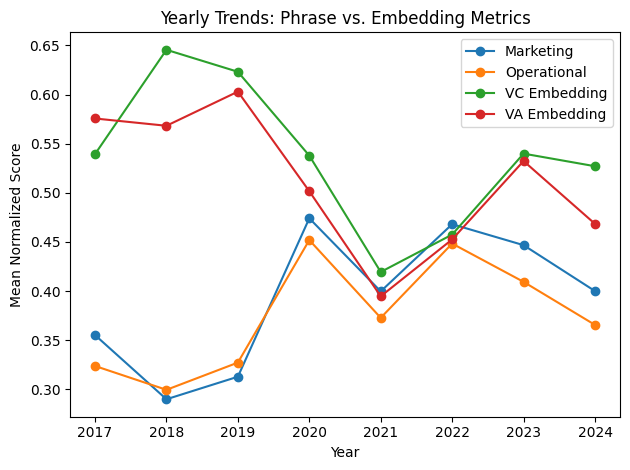

In [ ]:


# 1. Normalize CIK to string (without losing leading zeros where needed)
final_df['CIK']           = final_df['CIK'].astype(str)
va_vc_embeddings['CIK']   = va_vc_embeddings['CIK'].astype(str).str.zfill(final_df['CIK'].str.len().max())

# 2. Rename and coerce year
va_vc_embeddings['year']  = va_vc_embeddings['Year'].astype(int)
# final_df already has `year` as int

# 3. Merge on the now-matching keys
merged = pd.merge(
    final_df,
    va_vc_embeddings[['CIK','year','VC_Embedding_Score (%)','VA_Embedding_Score (%)','Filename']],
    on=['CIK','year'],
    how='inner',
    validate='one_to_one'
)

# 4. Proceed with your normalization + plotting logic
def minmax(x):
    return (x - x.min())/(x.max() - x.min()) if x.max()!=x.min() else 0

for orig in ['net_marketing_similarity','net_operational_similarity',
             'VC_Embedding_Score (%)','VA_Embedding_Score (%)']:
    norm_col = orig.lower().replace(' ','_').replace('(%','').replace(')','') + '_norm'
    merged[norm_col] = merged.groupby('year')[orig].transform(minmax)

# Yearly trends
yearly = merged.groupby('year')[
    ['net_marketing_similarity_norm','net_operational_similarity_norm',
     'vc_embedding_score__norm','va_embedding_score__norm']
].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure()
plt.plot(yearly['year'], yearly['net_marketing_similarity_norm'], marker='o', label='Marketing')
plt.plot(yearly['year'], yearly['net_operational_similarity_norm'], marker='o', label='Operational')
plt.plot(yearly['year'], yearly['vc_embedding_score__norm'], marker='o', label='VC Embedding')
plt.plot(yearly['year'], yearly['va_embedding_score__norm'], marker='o', label='VA Embedding')
plt.xlabel('Year')
plt.ylabel('Mean Normalized Score')
plt.title('Yearly Trends: Phrase vs. Embedding Metrics')
plt.legend()
plt.tight_layout()
plt.show()
